# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split #импорт модуля разделения из специального модуля библиотеки sklearn
from sklearn.linear_model import LinearRegression #импорт модуля линейной регрессии

from sklearn.metrics import mean_squared_error #квадратичные отклонения
from scipy import stats as st

### Загружаем данные

#### Описание данных

- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек;
- `product` — объём запасов в скважине (тыс. баррелей).

#### Условия задачи

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

*Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.*

#### Загрузка датасетов

In [4]:
# открываем таблицу geo_data_0:
try:
    first_region = pd.read_csv('/datasets/geo_data_0.csv')
except:
    try:
        first_region = pd.read_csv(r'E:\Practicum\2_Projects_Git\8_business_ml_borehole\geo_data_0.csv')
    except:
        first_region = pd.read_csv('geo_data_0.csv')
first_region

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [5]:
# открываем таблицу geo_data_1:
try:
    second_region = pd.read_csv('/datasets/geo_data_1.csv')
except:
    try:
        second_region = pd.read_csv(r'E:\Practicum\2_Projects_Git\8_business_ml_borehole\geo_data_1.csv')
    except:
        second_region = pd.read_csv('geo_data_1.csv')
second_region

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


In [6]:
# открываем таблицу geo_data_2:
try:
    third_region = pd.read_csv('/datasets/geo_data_2.csv')
except:
    try:
        third_region = pd.read_csv(r'E:\Practicum\2_Projects_Git\8_business_ml_borehole\geo_data_2.csv')
    except:
        third_region = pd.read_csv('geo_data_2.csv')
third_region

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


### Предобработка данных

#### Пропуски

In [7]:
first_region.info() #выводим инвормацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
second_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
third_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Все датасеты заполнены данными. Пропусков - нет.

#### Типы данных

Из информации выше видим, что все типы данных заполнены корректно.

#### Явные дубликаты

In [10]:
display(first_region.duplicated().sum()) #показать дубликаты
display(second_region.duplicated().sum())
display(third_region.duplicated().sum())


0

0

0

Явных дубликатов нет. Несмотря на то, что это разные регионы, проверим, нет ли в среди них общих данных.

In [9]:
frames = [first_region, second_region, third_region] #список датасетов
common_table_to_find_duplicate = pd.concat(frames) #склеить
display(common_table_to_find_duplicate.duplicated().sum()) #показать дубликаты


0

#### Строим гистограммы

Построив гистограммы, сможем проследить, есть ли явные выбросы в признаках.

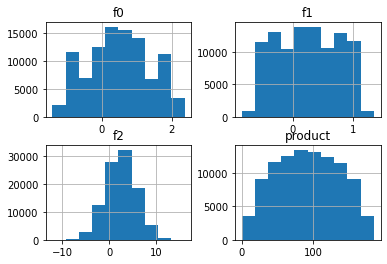

In [10]:
first_region.hist(); #строим гистограммы

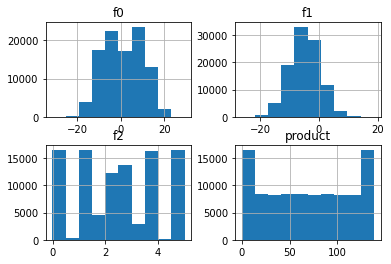

In [11]:
second_region.hist();

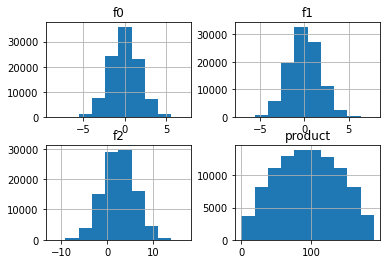

In [12]:
third_region.hist();

Так как мы по условию не знаем, что это за признаки, судить о том, что изображено на гистограммах сложно. Главное сейчас то, что мы видим, что явных выбросов данных не наблюдается.

### Выводы по подготовке данных

Здесь были загружены и рассмотрены данные. В целом, данные чистые, без пропусков и выбросов.

## Обучение и проверка модели

Из условия - для обучения модели подходит только линейная регрессия, т.к. остальные модели недостаточно предсказуемые. 

Загружаем необходимые библиотеки (все библиотеке находятся в начале проекта).

### Удаление лишних данных

Идентификаторы скважин не помогут при обучении модели, тем более, что модель должна работать с числовыми данными.

In [13]:
first_region = first_region.drop(['id'], axis=1) #удаляем ненужный столбец
second_region = second_region.drop(['id'], axis=1)
third_region = third_region.drop(['id'], axis=1)

### Разбиение данных

Разобьем датасеты на 2 выборки:

- тренировочную - на которой мы обучаем модели,
- валидационную - на которой они проходят проверку качества.

Разбиваем данные в отношении 75/25.

In [14]:
RANDOM_STATE = 1000 #выносим константную переменную

In [15]:
#разделение исходного датасета на две выборки, обучающую и валидационную одновременно с разделением на матрицу признаков и целевой признак

first_region_features_train, first_region_features_valid, first_region_target_train, first_region_target_valid = train_test_split( #создаем 4 датасета, два признаков (тест+валидация) и два целевых, 
    first_region.drop(columns='product'), #для датасетов признаков удаляем целевой
    first_region['product'], #для целевого оставляем только целевой
    test_size=0.25, #с соотношением 75/25
    random_state=RANDOM_STATE) #с заданной опорой для рандома 

In [16]:
second_region_features_train, second_region_features_valid, second_region_target_train, second_region_target_valid = train_test_split( #создаем 4 датасета, два признаков (тест+валидация) и два целевых, 
    second_region.drop(columns='product'), #для датасетов признаков удаляем целевой
    second_region['product'], #для целевого оставляем только целевой
    test_size=0.25, #с соотношением 75/25
    random_state=RANDOM_STATE) #с заданной опорой для рандома 

In [17]:
third_region_features_train, third_region_features_valid, third_region_target_train, third_region_target_valid = train_test_split( #создаем 4 датасета, два признаков (тест+валидация) и два целевых, 
    third_region.drop(columns='product'), #для датасетов признаков удаляем целевой
    third_region['product'], #для целевого оставляем только целевой
    test_size=0.25, #с соотношением 75/25
    random_state=RANDOM_STATE) #с заданной опорой для рандома 

### Обучение модели

In [18]:
first_region_model = LinearRegression()
first_region_model.fit(first_region_features_train, first_region_target_train) # обучаем модель на тренировочной выборке
first_region_predictions_valid = first_region_model.predict(first_region_features_valid) # получаем предсказания модели на валидационной выборке

first_region_rmse = mean_squared_error(first_region_target_valid, first_region_predictions_valid)**0.5 # считаем значение метрики RMSE на валидационной выборке

In [19]:
second_region_model = LinearRegression()
second_region_model.fit(second_region_features_train, second_region_target_train) # обучаем модель на тренировочной выборке
second_region_predictions_valid = second_region_model.predict(second_region_features_valid) # получаем предсказания модели на валидационной выборке

second_region_rmse = mean_squared_error(second_region_target_valid, second_region_predictions_valid)**0.5 # считаем значение метрики RMSE на валидационной выборке

In [20]:
third_region_model = LinearRegression()
third_region_model.fit(third_region_features_train, third_region_target_train) # обучаем модель на тренировочной выборке
third_region_predictions_valid = third_region_model.predict(third_region_features_valid) # получаем предсказания модели на валидационной выборке

third_region_rmse = mean_squared_error(third_region_target_valid, third_region_predictions_valid)**0.5 # считаем значение метрики RMSE на валидационной выборке

### Предсказания и правильные ответы

#### Первый регион

In [21]:
first_region_valid_predictions_compare = pd.DataFrame({ #созаем датафрейм
    'Реальные данные (тыс.барр.)': first_region_target_valid, #значения первого столбца
    'Предсказания (тыс.барр.)': first_region_predictions_valid, #второго столбца
    'Отклонение (тыс.барр.)': first_region_target_valid - first_region_predictions_valid, #третьего столбца
}) #

display(first_region_valid_predictions_compare) #выводим датасет
print('Квадратный корень из среднего квадратичного отклонения для первого региона равен',\
first_region_rmse.round(2), 'тысяч баррелей.') #выводим значение округленное до двух знаков после запятой
print('Средний запас предсказанного сырья в первом регионе равен',\
first_region_valid_predictions_compare['Предсказания (тыс.барр.)'].mean().round(2), 'тысяч баррелей.')

,Реальные данные (тыс.барр.),Предсказания (тыс.барр.),Отклонение (тыс.барр.)
81768,100.045890,67.733720,32.312170
72785,78.683928,105.404537,-26.720610
16208,107.657789,81.851305,25.806485
39960,24.215565,95.388786,-71.173220
61947,132.930497,102.793228,30.137269
...,...,...,...
14547,99.818540,125.038339,-25.219799
24357,79.679482,73.082671,6.596812
87579,36.131852,93.630333,-57.498481
11835,107.307639,62.276899,45.030739


Квадратный корень из среднего квадратичного отклонения для первого региона равен 37.76 тысяч баррелей.
Средний запас предсказанного сырья в первом регионе равен 92.83 тысяч баррелей.


#### Второй регион

In [22]:
second_region_valid_predictions_compare = pd.DataFrame({ #созаем датафрейм
    'Реальные данные (тыс.барр.)': second_region_target_valid, #
    'Предсказания (тыс.барр.)': second_region_predictions_valid, #
    'Отклонение (тыс.барр.)': second_region_target_valid - second_region_predictions_valid, 
}) #

display(second_region_valid_predictions_compare)
print('Квадратный корень из среднего квадратичного отклонения для второго региона равен',
second_region_rmse.round(2), 'тысяч баррелей.')
print('Средний запас предсказанного сырья в первом регионе равен',\
second_region_valid_predictions_compare['Предсказания (тыс.барр.)'].mean().round(2), 'тысяч баррелей.')

,Реальные данные (тыс.барр.),Предсказания (тыс.барр.),Отклонение (тыс.барр.)
81768,137.945408,137.902269,0.043139
72785,3.179103,2.263871,0.915231
16208,53.906522,55.220075,-1.313553
39960,57.085625,56.276908,0.808717
61947,84.038886,82.161567,1.877319
...,...,...,...
14547,110.992147,109.996572,0.995575
24357,26.953261,28.423620,-1.470359
87579,26.953261,27.337965,-0.384704
11835,57.085625,57.525416,-0.439792


Квадратный корень из среднего квадратичного отклонения для второго региона равен 0.89 тысяч баррелей.
Средний запас предсказанного сырья в первом регионе равен 68.87 тысяч баррелей.


#### Третий регион

In [23]:
third_region_valid_predictions_compare = pd.DataFrame({ #созаем датафрейм
    'Реальные данные (тыс.барр.)': third_region_target_valid, #
    'Предсказания (тыс.барр.)': third_region_predictions_valid, #
    'Отклонение (тыс.барр.)': third_region_target_valid - third_region_predictions_valid, 
}) #

display(third_region_valid_predictions_compare)
print('Квадратный корень из среднего квадратичного отклонения для третьего региона равен',
third_region_rmse.round(2), 'тысяч баррелей.')
print('Средний запас предсказанного сырья в первом регионе равен',\
third_region_valid_predictions_compare['Предсказания (тыс.барр.)'].mean().round(2), 'тысяч баррелей.')

,Реальные данные (тыс.барр.),Предсказания (тыс.барр.),Отклонение (тыс.барр.)
81768,115.049411,104.703919,10.345492
72785,21.295180,75.184100,-53.888920
16208,100.392207,85.507941,14.884266
39960,128.373088,105.440508,22.932580
61947,41.165072,101.834554,-60.669481
...,...,...,...
14547,159.330951,114.757953,44.572998
24357,138.107642,95.790620,42.317022
87579,42.824350,64.284792,-21.460442
11835,155.678207,110.231534,45.446673


Квадратный корень из среднего квадратичного отклонения для третьего региона равен 39.88 тысяч баррелей.
Средний запас предсказанного сырья в первом регионе равен 94.95 тысяч баррелей.


### Полученные результаты

In [24]:
df_mean_values = pd.DataFrame({ #созаем датафрейм
    'Регион': ['first_region', 'second_region', 'third_region'], #
    'Реальный объем (сред., тыс. барр.)': [
        first_region_valid_predictions_compare['Реальные данные (тыс.барр.)'].mean().round(2), #забираем значения реальных данных из датафреймов, считаем среднее для каждого, округляем
        second_region_valid_predictions_compare['Реальные данные (тыс.барр.)'].mean().round(2),
        third_region_valid_predictions_compare['Реальные данные (тыс.барр.)'].mean().round(2)
        ], #
    'Предсказанный объем (сред., тыс. барр.)': [
        first_region_valid_predictions_compare['Предсказания (тыс.барр.)'].mean().round(2), #забираем значения предсказанных данных из датафреймов, считаем среднее для каждого, округляем
        second_region_valid_predictions_compare['Предсказания (тыс.барр.)'].mean().round(2),
        third_region_valid_predictions_compare['Предсказания (тыс.барр.)'].mean().round(2)
        ],
    'RMSE': [first_region_rmse.round(2), second_region_rmse.round(2), third_region_rmse.round(2)] #значения RMSE
}) #
df_mean_values #вывод датасета


,Регион,"Реальный объем (сред., тыс. барр.)","Предсказанный объем (сред., тыс. барр.)",RMSE
0,first_region,92.35,92.83,37.76
1,second_region,68.85,68.87,0.89
2,third_region,94.70,94.95,39.88


### Выводы по обучению моделей

Данные были разбиты на матрицу признаков и целевой признак, а также на тренировочные и валидационные выборки в нужной пропорции. Модели линейной регрессии были обучены, найдены квадратные корни из средних квадратичных отклонений. Исходя из полученных результатов, пока видим, что данные из `second_region` - то есть второго региона, имеют наименьший разброс. Также, разницу между распределением целевого признака датасетов можем у видеть на гистограммах.

Составлены таблицы предсказаний и отклонений от реальных данных. Исходя из полученных данных и гистограмм, можно увидеть, что первый и третий регионы по набору данных похожи. Второй регион значительно отличается.

## Подготовка к расчёту прибыли

### Введем константы

In [25]:
#вводим константы
points = 500 
best_points = 200
budget = 10*10**9 #
benefit = 450*10**3

### Безубыточная добыча

Так как бюджет на разработку скважин в регионе включает в себя 200 лучших скважин, то на разработку одной скважины в одном регионе бюджет (рублей):

In [26]:
budget_per_one = budget / best_points #бюджет на одну скважину
budget_per_one

50000000.0

Т.к. доход с каждой единицы 450 000 рублей, можем найти среднее значение необходимого количества баррелей, для неубыточной скважины:

In [27]:
mean_value_barr = budget_per_one / benefit #среднее значение количества нефти, для окупаемости скважины
mean_value_barr

111.11111111111111

### Вывод по разделу

Итак, чтобы разработка двухсот скважин при заданном бюджете и стоимости нефти окупилась, в среднем они должны приносить 111.11 тыс. баррелей нефти.

Из данных, полученных выше, следует, что текущие реальные и предсказанные средние показатели намного ниже, особенно во втором регионе `second_region`.

## Расчёт прибыли и рисков 

### Расчет прибыли

Напишем функцию для расчета прибыли для духсот самых успешных,согласно предсказанию,скважин. Но при этом прибыль будем считать на реальных данных: прибыль - это оборот минус себестоимость (бюджет).

In [28]:
def revenue(target, probabilities, count): #создаем функцию
    probs_sorted = pd.Series(probabilities).sort_values(ascending=False) #предсказанные значения отсортированы в порядке убывания (применяем к ним Series)
    selected = target[probs_sorted.index][:count] #реальные данные с индексами предсказаний, срез до константного значения
    return benefit * selected.sum() - budget #возвращаем это значение

In [29]:
bore_first = revenue(first_region_valid_predictions_compare['Реальные данные (тыс.барр.)'], \
    first_region_valid_predictions_compare['Предсказания (тыс.барр.)'], best_points) #применяем к функции аргументы, для которых операции описаны в теле функции

bore_second = revenue(second_region_valid_predictions_compare['Реальные данные (тыс.барр.)'], \
    second_region_valid_predictions_compare['Предсказания (тыс.барр.)'], best_points)

bore_third = revenue(third_region_valid_predictions_compare['Реальные данные (тыс.барр.)'], \
    third_region_valid_predictions_compare['Предсказания (тыс.барр.)'], best_points)

bore_table = pd.DataFrame({ #созаем датафрейм
    'Регион': ['first_region', 'second_region', 'third_region'], #
    'Прибыль': [bore_first, bore_second, bore_third],
}) #
bore_table

,Регион,Прибыль
0,first_region,3.120037e+09
1,second_region,2.415087e+09
2,third_region,2.588875e+09


Найдены значения прибыли для каждого региона, основанные на реальных данных, но для самых потенциально прибыльных скважин. Наибольшую прибыль может обеспечить первый регион, за ним, с большим отрывом следуют третий и второй регионы.

Прибыль - порядка 2.5 - 3 млрд. рублей для самых потенциально прибыльных скважин, что составляет порядка 25 - 30% от вложений на разработку, помимо, конечно, 100% окупаемости.

### Расчет рисков

Для того, чтобы найти вероятность того, что скважины в регионе могут быть убыточными, нужно найти те, что не приносят доход. То есть из прибыль < 0 рублей.

Оценим вероятность убытков для каждого региона, взяв для исследования 500 скважин, и исследуя 200 лучших из них. Также найдем среднюю прибыль для каждого региона и 95%-й доверительный интервал, применяя метод Bootstrap.

In [30]:
def bootstap(target, probabilities, common_count): #создаем функцию

    state = np.random.RandomState(RANDOM_STATE) #вводим дляэтой функции рандомайз (иначе будет считать одно и то же значение)
    values = [] #создаем пустой список
    count=0 #счетчик

    for i in range(1000): #bootstrep c 1000 перебираемых значений
        target_subsample = target.sample(common_count, replace=True, random_state=state) #данные для таргета, количество - по аргументу
        probs_subsample = probabilities[target_subsample.index] #предсказания с индексом таргета (здесь наоборот)
        values.append(revenue(target_subsample, probs_subsample, best_points)) #добавляем в список первую функцию с ее аргументами и операциями над ними, описанными выше

    for i in values: #включаем счетчик
        if i < 0:
            count +=1 #считаем число убыточных скважин

    values = pd.Series(values) #преобразовываем список в объект сериес
    lower = values.quantile(.025) #2.5% квантиль - значение, ниже которого 2.5% данных
    upper = values.quantile(.975) #97.5% квантиль - значение, выше которого 2.5% данных, в сумме - доверительный интервал 95%
    mean = values.mean() #среднее
    
    print("Средняя прибыль:", mean.round(2)) #вывод с округлением до 2 знаков после ,
    print("2.5%-квантиль:", lower.round(2))
    print("97.5%-квантиль:", upper.round(2))
    print ('Вероятность убытка: {:.1%}'.format(count/1000)) #вывод %. делим на 1000, т.к. количество values = 1000


In [31]:
bootstap(first_region_valid_predictions_compare['Реальные данные (тыс.барр.)'], \
    first_region_valid_predictions_compare['Предсказания (тыс.барр.)'], points) #применяем к функции аргументы, для которых операции описаны в теле функции

Средняя прибыль: 435079550.95
2.5%-квантиль: -95943225.87
97.5%-квантиль: 949409968.24
Вероятность убытка: 5.6%


In [32]:
bootstap(second_region_valid_predictions_compare['Реальные данные (тыс.барр.)'], \
    second_region_valid_predictions_compare['Предсказания (тыс.барр.)'], points)

Средняя прибыль: 500573282.14
2.5%-квантиль: 45318148.56
97.5%-квантиль: 925747456.82
Вероятность убытка: 1.2%


In [33]:
bootstap(third_region_valid_predictions_compare['Реальные данные (тыс.барр.)'], \
    third_region_valid_predictions_compare['Предсказания (тыс.барр.)'], points)

Средняя прибыль: 402347292.09
2.5%-квантиль: -145122898.89
97.5%-квантиль: 947350954.88
Вероятность убытка: 6.5%


In [34]:
#собираем датасет из полученных данных
resuls_table = pd.DataFrame(index=['Средняя прибыль скважины в регионе, руб', '2.5%-квантиль, руб', '97.5%-квантиль, руб', 'Вероятность убытка, %'], \
    columns=['first_region','second_region','third_region'])

resuls_table['first_region'] = '435079550.95', '-95943225.87', '949409968.24', '5.6%'
resuls_table['second_region'] = '500573282.14', '45318148.56', '925747456.82', '1.2%'
resuls_table['third_region'] = '402347292.09', '-145122898.89', '947350954.88', '6.5%'
resuls_table


,first_region,second_region,third_region
"Средняя прибыль скважины в регионе, руб",435079550.95,500573282.14,402347292.09
"2.5%-квантиль, руб",-95943225.87,45318148.56,-145122898.89
"97.5%-квантиль, руб",949409968.24,925747456.82,947350954.88
"Вероятность убытка, %",5.6%,1.2%,6.5%


Мы видим, что только второй регион удовлетворяет условию: вероятность убытков меньше 2.5%.

## Выводы

В проекте мы рассмотрели три региона, где можно добывать нефть. Мы обработали данные, построили обучающие модели и предсказали, какие скважины максимально потенциально прибыльные. 

Были рассчитаны реальные объемы добытой нефти для этих скважин и найдены средние значения. 

Так как одной из задач проекта было рассчитать прибыль и риски, были рассчитаны средние показатели окупаемости, причем, ни один из регионов по среднему значению добываемой нефти не превосходит значение окупаемости. 
- Значение добываемой нефти для окупаемости для текущих исходных данных: 111.11 тыс. баррелей.
- Средние значения для скважины в первом регионе - около 92 тыс. баррелей, во втором регионе - около 69 тыс. баррелей, в третьем - около 95 тыс. баррелей. При этом для первого и третьего регионов разброс значений превышает почти в 50 раз второй регион.

Поэтому, для кажного региона взяты случайные 500 скважин, и для 200 лучших из них рассчитаны значения суммарной прибыли. Суммарная прибыль с этих скважин максимальна для первого региона и составляет около 3 млрд. и 120 млн. рублей. Второй и третий регионы принесут порядка 2.4-2.6 млрд. рублей.

Тем не менее, несмотря на то, что первый регион является самым потенциально прибыльным, он не проходит проверку на допустимые риски, порог которых составляет 2,5%. Риски для регионов:
- первый регион 5,6%,
- второй регион 1,2%,
- третий регион 6,5%.

Также, была рассчитана средняя прибыль по регионам, которая показала максимальное значение для второго региона: ~500 млн. рублей (для остальных - около 400-430 млн. рублей).

Найдены 95%-е доверительные интервалы с помощью квантилей (здесь значения приблизительные).
- первый регион от -96 до 950 млн. рублей,
- второй регион от 450 до 925 млн. рублей,
- третий регион от -145 до 947 млн. рублей.

Видим, что второй регион обладает минимальным разбросом.

Из всего вышеперечисленного следует, что при текущих исходных данных и заданных условиях, единственный регион, который можно предложить для разработки - второй.